# Лабораторная работа 3

In [211]:
import requests
import json
import numpy as np
import pandas as pd
import pickle
import os
from tqdm import tqdm
from pprint import pprint
import csv
import networkx as nx

# Задание 1

Будем использовать VK API. Зададим сервисный токен (он уже не действует, я его обновил в целях безопасности), версию API и ID групп. Для анализа были выбраны группы 'Мои любимые юморески" (около 509 тыс. подписчиков) - популярная группа с анекдотами, и "хайер скул ов мемс" (около 90 тыс. подписчиков) - группа с мемами про ВШЭ. 

Предположительно, относительно большая доля любитилей мемов из группы "хайер скул ов мемс" состоит и в "юморесках", но не наоборот. Посмотрим, правда ли это и отразится ли это на схожести групп.

In [101]:
token = "ca1d4830ca1d4830ca1d4830a9c90bd96bcca1dca1d4830af6f9c238620df9dc76b12a7"
version = "5.199"
group_id_1 = "jumoreski"
group_id_2 = "hsemem"

Получим данные о пользователях групп (идентефикаторы пользователей) с помощью запроса `groups.getMembers`. Выведем количество подписчиков и первые 10 идентефикаторов.

In [102]:
data = requests.get("https://api.vk.com/method/groups.getMembers", 
                   params = {
                       "access_token": token,
                       "v": version,
                       "group_id": group_id_1,
                       "count": 1000,
                       "offset": 0
                   }).json()

count_1 = data['response']['count']
ids_1 = data['response']['items']

print(f"Group 1:\nNumber of members: {count_1}\nIDs: {' '.join(map(str, ids_1[:10]))} ...")

data = requests.get("https://api.vk.com/method/groups.getMembers", 
                   params = {
                       "access_token": token,
                       "v": version,
                       "group_id": group_id_2,
                       "count": 1000,
                       "offset": 0
                   }).json()

count_2 = data['response']['count']
ids_2 = data['response']['items']

print(f"Group 2:\nNumber of members: {count_2}\nIDs: {' '.join(map(str, ids_2[:10]))} ...")

Group 1:
Number of members: 509011
IDs: 510 720 908 930 940 1018 1116 1185 2136 2194 ...
Group 2:
Number of members: 90212
IDs: 1257 1389 2050 2932 4913 6559 8612 9147 9804 10615 ...


К сожалению, VK API позволяет получить данные только о 1000 пользователях за раз. Поэтому несколько раз сделаем запрос, каждый раз сдвигая выборку на 1000 с помощью параметра `offset`. Идентефикаторы пользователей запишем в файлы.

Это первый времязатратный процесс (второй - выгрузка данных о самих пользователях по ID), поэтому сделаем проверку на существование файла. Если файл существует, не будем его создавать заново.

In [124]:
def load_data(group_id, filename):
    #checking if files do not exist or are empty 
    does_exist = (os.path.isfile(filename)) and (not os.stat(filename).st_size == 0)
    if does_exist:
        print(f"File {filename} already exists.")
        return
    
    #getting the number of members
    count = requests.get("https://api.vk.com/method/groups.getMembers", 
                   params = {
                       "access_token": token,
                       "v": version,
                       "group_id": group_id,
                       "count": 1
                   }).json()['response']['count']
    
    #extracting data
    with open(filename, 'wb') as f:
        for iter in tqdm(range(count // 1000), desc = "Loading data"):
            data = requests.get("https://api.vk.com/method/groups.getMembers", 
                                params = {
                                    "access_token": token,
                                    "v": version,
                                    "group_id": group_id,
                                    "count": 1000,
                                    "offset": iter * 1000
                                }).json()
            user_ids = data['response']['items']
            for user_id in user_ids:
                pickle.dump(user_id, f)


load_data(group_id_1, "IDs1.bin")
load_data(group_id_2, "IDs2.bin")

File IDs1.bin already exists.


Loading data:: 100%|██████████| 90/90 [00:36<00:00,  2.46it/s]


Сохраним ID в списках.

In [125]:
ids_1 = []
with open("IDs1.bin", 'rb') as f:
    while True:
        try:
            ids_1.append(pickle.load(f))
        except EOFError:
            break

ids_2 = []
with open("IDs2.bin", 'rb') as f:
    while True:
        try:
            ids_2.append(pickle.load(f))
        except EOFError:
            break

print(f"1. Length: {len(ids_1)}, items: {' '.join(map(str, ids_1[:10]))} ...")
print(f"2. Length: {len(ids_2)}, items: {' '.join(map(str, ids_2[:10]))} ...")

1. Length: 509000, items: 510 720 908 930 940 1018 1116 1185 2136 2194 ...
2. Length: 90000, items: 1257 1389 2050 2932 4913 6559 8612 9147 9804 10615 ...


Теперь получим данные о пользователях с помощью запроса `users.get` (второй времязатратный процесс). Для каждого пользователя запросим имя, пол, город, возраст (приблизительно вычислим через год рождения), род деятельнсоти (школа, университет, работа), "главное в людях" и "главное в жизни" (из дополнительной информации).

In [201]:
def load_user_info(ids: list[int], filename, fields: list[str]):
    #checking if files do not exist or are empty 
    does_exist = (os.path.isfile(filename)) and (not os.stat(filename).st_size == 0)
    if does_exist:
        print(f"File {filename} already exists.")
        return

    #creating the list of rows for our future dataframe
    rows = []
    
    #loading the data by 1000 items
    for iter in tqdm(range(len(ids) // 1000), desc="Loading batch"):
        data = requests.get("https://api.vk.com/method/users.get", 
                            params = {
                                "access_token": token,
                                "v": version,
                                "user_ids": ",".join(map(str, ids[iter*1000:(iter+1)*1000])),
                                "fields": ",".join(fields)
                            }).json()
        
        users_info = data['response']
        for user in tqdm(users_info, desc="Loading user", leave=False):
            user_standardized = dict() #will create a dictionary with given fields (possibly modified)
            for field in fields:
                match field:
                    case "id" | "first_name" | "last_name": #required fields
                        user_standardized[field] = user[field]

                    case "bdate": #instead of the birth date we will only store an age, if the birth year is known
                        if "bdate" in user.keys() and len(user["bdate"].split('.')) == 3:
                            user_standardized["age"] = 2023 - int(user["bdate"].split('.')[2])
                        else:
                            user_standardized["age"] = None

                    case "sex": #instead of 0, 1 and 2 we will store "unspecified", "female" and "male"
                        match user.get("sex", 0):
                            case 0: user_standardized["sex"] = "unspecified"
                            case 1: user_standardized["sex"] = "female"
                            case 2: user_standardized["sex"] = "male"

                    case "city": #will only store the name
                        user_standardized["city"] = user.get("city", {"title" : None})["title"]

                    case "occupation": #will only store type
                        user_standardized["occupation"] = user.get("occupation", {"type" : None})["type"]
                    
                    case "personal": #will only store people_main and life_main
                        people_main = user.get("personal", {"people_main" : None}).get("people_main", None)
                        life_main = user.get("personal", {"life_main" : None}).get("life_main", None)
                        match people_main:
                            case None: user_standardized["people_main"] = None
                            case 1: user_standardized["people_main"] = "ум и креативность"
                            case 2: user_standardized["people_main"] = "доброта и честность"
                            case 3: user_standardized["people_main"] = "красота и здоровье"
                            case 4: user_standardized["people_main"] = "власть и богатство"
                            case 5: user_standardized["people_main"] = "смелость и упорство"
                            case 6: user_standardized["people_main"] = "юмор и жизнелюбие"
                        match life_main:
                            case None: user_standardized["life_main"] = None
                            case 1: user_standardized["life_main"] = "семья и дети"
                            case 2: user_standardized["life_main"] = "карьера и деньги"
                            case 3: user_standardized["life_main"] = "развлечения и отдых"
                            case 4: user_standardized["life_main"] = "наука и исследования"
                            case 5: user_standardized["life_main"] = "совершенствование мира"
                            case 6: user_standardized["life_main"] = "саморазвитие"
                            case 7: user_standardized["life_main"] = "красота и искусство"
                            case 8: user_standardized["life_main"] = "слава и влияние"
                                
                    case _:
                        #possibly display warning
                        pass

            rows.append(user_standardized)
        
    #creating the dataframe and dumping it to a file
    df = pd.DataFrame.from_dict(rows, orient='columns')
    df.to_csv(filename, index=False)

    return


fields = ['id', 'first_name', 'last_name', 'sex', 'city', 'bdate', 'occupation', 'personal', 'relation']
load_user_info(ids_1, "users1.csv", fields)
load_user_info(ids_2, "users2.csv", fields)

File users1.csv already exists.


Loading batch:   0%|          | 0/90 [00:00<?, ?it/s]

Loading batch: 100%|██████████| 90/90 [02:33<00:00,  1.71s/it]


Выгрузим данные из файлов в `pandas DataFrame` и посмотрим на их содержание.

In [202]:
df1 = pd.read_csv("users1.csv")
df1.head(20)

,id,first_name,last_name,sex,city,age,occupation,people_main,life_main
0,510,Anatoly,Karpenko,male,NaN,NaN,NaN,NaN,NaN
1,720,Yury,Kossakovsky,male,Saint Petersburg,NaN,university,NaN,NaN
2,908,Georgy,Chelidze,male,Saint Petersburg,35.0,NaN,NaN,NaN
3,930,Roma,Zlatyev,male,Saint Petersburg,NaN,NaN,NaN,NaN
4,940,Irakly,Antia,male,Saint Petersburg,37.0,work,NaN,NaN
5,1018,Yarik,Burim,male,Saint Petersburg,NaN,work,NaN,NaN
6,1116,Igor,Schavelyov-Sadomovsky,male,Saint Petersburg,NaN,university,NaN,NaN
7,1185,Alexey,Mogilov,male,Novomoskovsk,NaN,work,NaN,NaN
8,2136,Yaroslav,Tekhnik,male,Ryazan,NaN,work,NaN,NaN
9,2194,Alan,Wanker,male,NaN,NaN,NaN,NaN,NaN


In [203]:
df2 = pd.read_csv("users2.csv")
df2.head(20)

,id,first_name,last_name,sex,city,age,occupation,people_main,life_main
0,1257,Oleg,Urzhumtsev,male,İstanbul,34.0,university,NaN,NaN
1,1389,Ivan,Bezborody,male,Nizhny Novgorod,NaN,university,NaN,NaN
2,2050,Katya,Lebedeva,female,Saint Petersburg,NaN,work,NaN,NaN
3,2932,Kirill,Kogortov,male,Saint Petersburg,NaN,NaN,NaN,NaN
4,4913,Marina,Sekacheva,female,Saint Petersburg,39.0,university,NaN,NaN
5,6559,Fedor,Klimenko,male,Barnaul,39.0,work,доброта и честность,семья и дети
6,8612,Anastasia,Obolenskaya,female,Phuket,27.0,university,NaN,NaN
7,9147,Viktor,Shayer,male,Saint Petersburg,NaN,university,юмор и жизнелюбие,совершенствование мира
8,9804,Nikita,Beshta,male,NaN,35.0,university,NaN,NaN
9,10615,Darya,Lebedeva,female,Saint Petersburg,NaN,work,NaN,NaN


Видим, что в данных много пропусков. Нет пропусков только в полях `id`, `first_name`, `second_name` и `sex`. Это, возможно, усложнит нам задачу в будущем.

# Задание 2

Пусть $A$ и $B$ обозначают множества подписчиков групп. Можно придумать несколько метрик для измерения схожести групп (в порядке убывания разумности):
1. $\displaystyle \frac{|A \cap B|}{|A \cup B|}$ (коэффициент Жаккара);

    $\displaystyle 1-\frac{|A \cap B|}{|A \cup B|}$ (расстояние Жаккара);

    Плюсы:
    - Расстояние Жаккара обладает стандартными свойствами расстояния.
    - Если группы совпадают, принимают значение 1, если нет общих подписчиков - 0 (логично);
    - Если одна группа содержится в другой, вычисляется как отношение меньшего числа подписчиков к большему (логично);
    
    Минусы:
    - Не учитывает похожих, но не одинаковых подписчиков (например, если города подписчиков часто совпадают, но совпадений по подписчикам мало, группы все равно логично считать похожими);

    В эту же категорию можно отнести Коэффициент Симпсона $\displaystyle \left( \frac{|A \cap B|}{\min{(|A|, |B|)}} \right)$, коэффициент Сёренсена $\displaystyle \left( \frac{2|A \cap B|}{|A| + |B|} \right)$, коэффициент Браун-Бланке $\displaystyle \left( \frac{|A \cap B|}{\max{(|A|, |B|)}} \right)$ и т. п., но мне кажется, что это все примерно одно и то же.
2. Через схожесть значений признаков. Пусть мы сравниваем группы по городу. Посчитаем вектор доли встречаемых городов в группах:
    $$(\alpha^1_{\text{Москва}}, \alpha^1_{\text{Санкт-Петербург}},  \alpha^1_{\text{Новосибирск}} \dots) = (0.2, 0.1, 0.03 \dots)$$
    $$(\alpha^2_{\text{Москва}}, \alpha^2_{\text{Санкт-Петербург}},  \alpha^2_{\text{Новосибирск}} \dots) = (0.5, 0.3, 0.01 \dots)$$

    Тогда схожесть групп можно считать величиной, обратной расстоянию между этими векторами (например, Евклидовым). Если мы сравниваем по нескольким признакам, то можно вычислять сходство как (взвешенное) среднее этих расстояний. При желании можно привести все к интервалу от 0 до 1.

    Плюсы:
    - Учитывает похожих, но не одинаковых подписчиков;
    - Если группы совпадают, принимают значение 1;
    
    Минусы:
    - Сходство считается по выбраным нами субъективно признакам.

Вычислим первую из предложенных метрик.

#### Коэффициент Жаккара

In [206]:
common = pd.merge(df1, df2, how='inner')
common_count = common.shape[0]
common

,id,first_name,last_name,sex,city,age,occupation,people_main,life_main
0,283162,Alexander,Ivanov,male,Moscow,36.0,university,NaN,NaN
1,442103,Nuda,Vottak,female,NaN,NaN,NaN,NaN,NaN
2,608713,Artem,Vayboslav,female,NaN,32.0,university,NaN,NaN
3,624566,Linda,Saule,female,NaN,NaN,NaN,NaN,NaN
4,806597,Misha,Sapenyuk,male,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
10140,748091263,Yanis,Manelov,male,NaN,NaN,NaN,NaN,NaN
10141,749262819,Nannapat,Khunwang,female,NaN,23.0,university,NaN,NaN
10142,754676689,Sofya,Efanova,female,NaN,20.0,university,NaN,NaN
10143,774494504,Roman,Khovansky,male,NaN,NaN,NaN,NaN,NaN


In [213]:
jaccard_score = common.shape[0] / pd.merge(df1, df2, how='outer').shape[0]
simpson_score = common.shape[0] / min(df1.shape[0], df2.shape[0])
print(f"Коэффициент Жакарра: {jaccard_score*100:.2f} %")
print(f"Коэффициент Симпсона: {simpson_score*100:.2f} %")

Коэффициент Жакарра: 1.72 %
Коэффициент Симпсона: 11.27 %


Видим, что группы не сильно схожи по коэффициенту Жаккара, но тем не менее, более 10% подписчиков "хайер скул оф мемс" состоят в "юморесках". То есть был замечен эффект, о котором я говорил в начале работы.

## Задание 3

Для этого нам нужно выгрузить данные о друзьях каждого пользователя (будем соединять вершины ребром, если пользователи дружат).

In [247]:
def load_friends(ids: list[int], filename, max_iter):
    #checking if files do not exist or are empty 
    does_exist = (os.path.isfile(filename)) and (not os.stat(filename).st_size == 0)
    if does_exist:
        print(f"File {filename} already exists.")
        return

    #creating the list of rows for our future dataframe
    rows = []
    
    #loading the data by 1000 items
    for i, user_id in enumerate(tqdm(ids, desc="Loading batch")):
        data = requests.get("https://api.vk.com/method/friends.get", 
                            params = {
                                "access_token": token,
                                "v": version,
                                "user_id": user_id,
                            }).json()

        if not "error" in data.keys(): #skipping private users
            user_info = data['response']
            rows.append((user_id, set.intersection(set(user_info["items"]), set(ids))))

        if i >= max_iter:
            break
                
    #creating the dataframe and dumping it to a file
    df = pd.DataFrame.from_dict(rows, orient='columns')
    df.to_csv(filename, index=False)

    return

load_friends(ids_1, "friends1.csv", max_iter=1000) #will load 1000 users because I do not have time
load_friends(ids_2, "friends2.csv", max_iter=1000)

Loading batch:   1%|          | 1000/90000 [06:40<9:54:27,  2.50it/s]


In [250]:
df1 = pd.read_csv("friends1.csv")
df2 = pd.read_csv("friends2.csv")
df1

,0,1
0,720,{2469606}
1,940,"{11659649, 3433218, 39924226, 89477899, 200296..."
2,1185,set()
3,2136,{191203347}
4,3450,"{218996614, 117129605, 3362502}"
...,...,...
649,1927188,"{204045377, 248327170, 2361249, 21661028, 1444..."
650,1929207,set()
651,1945034,"{357186427, 57073932, 22795342}"
652,1946027,"{2119292, 116381985, 405598338, 415120835, 781..."


Далее эти таблицы легко преобразуются в таблицу ребер, но у меня не хватило времени.

##### Доработка

In [273]:
df1 = df1[:200] #selecting even smaller users as graphs take a lot of time to draw
df2 = df2[:200]

In [270]:
def get_edges(df):
    rows = []
    for i, user_id in tqdm(df.iloc[:, 0].items()):
        friendlist = df.iloc[i, 1][1:][:-1]
        if friendlist == "et(":
            continue
        for friend_id in list(map(int, df.iloc[i, 1][1:][:-1].split(","))):
            if (friend_id, user_id) not in rows:
                rows.append((user_id, friend_id))
    
    return pd.DataFrame(rows)


edges1 = get_edges(df1)
edges2 = get_edges(df2)
G1 = nx.from_pandas_edgelist(edges1, source=0, target=1)
G2 = nx.from_pandas_edgelist(edges2, source=0, target=1)


100it [00:00, 16676.49it/s]
100it [00:00, 503.34it/s]


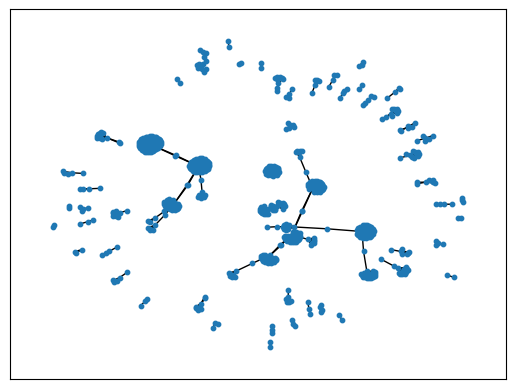

In [271]:
nx.draw_networkx(G1, with_labels=False, node_size=10)

Видим, что есть большие скопления друзей в середине и много отдельных маленьких групп (несложно понять, что вершин без ребер здесь быть не может). Это вполне ожидаемо: маленькие группы друзей вероятно являются друзьями и в жизни, поэтому существуют отдельно, а большие скопления - люди, которые знакомятся и которые, возможно, познакомились из-за общения в этой группе.

Мне кажется, если бы мы загрузили все данные, то мы бы получили большое ядро в центре и много отдельных маленьких групп.

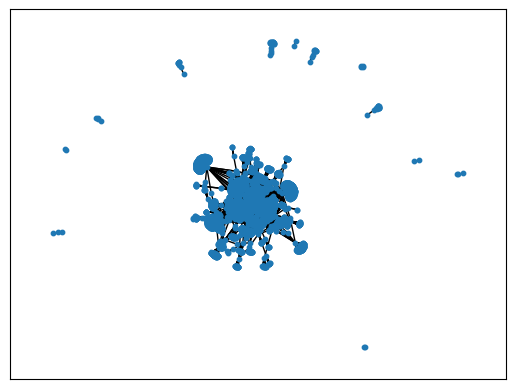

In [272]:
nx.draw_networkx(G2, with_labels=False, node_size=10)

Тут мы видим большое ядро в центре и небольшое число маленьких групп. Это тоже легко объясняется - подписчиков этой группы объединяет принадлежность к ВШЭ, поэтому существует много скоплений друзей, связанных в большое ядро.